In [1]:
# Important stuff
import os
import sys
from pathlib import Path
import json
import numpy as np
from typing import Tuple, Dict

# Enables the notebook to access root:
root_path = Path.cwd().parent
sys.path.append(str(root_path))

# Repo stuff
from geometry_metrics import compute_spectral_entropy, cosine_similarity_matrix, sliding_window, calculate_angles, plot_similarity_heatmap
from se_correlation import encode_labelset, compute_entropies

# Plots and pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import umap
from sklearn.decomposition import PCA

# CLIP/Torch
import clip
import torch
from torchvision.datasets import CIFAR100

# Statistics stuff
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import gaussian_kde

import warnings
# Suppress UMAP warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP ViT-L/14@336px...")
#Force the model to use float32:
model = clip.load("ViT-L/14@336px", jit=False, device=torch.device("cpu"))[0].to(device)
print(torch.version)
print(torch.version.hip)
print(torch.cuda.is_available()) 
print(torch.device("cuda"))

Loading CLIP ViT-L/14@336px...
<module 'torch.version' from '/home/albert/.local/lib/python3.12/site-packages/torch/version.py'>
None
True
cuda


In [3]:
Dataset = "Dataset" #coil100 doesn't want to work atm
embedding_path = f"../Embeddings/{Dataset}.json"
label_path = f"../Data/{Dataset}/labels.json"

with open(embedding_path, "r", encoding="utf-8") as f:
    embedding_dict = json.load(f)["rot"]

for obj in embedding_dict:
    embedding_dict[obj] = np.array(
        [embedding_dict[obj][str(key)] for key in sorted(map(int, embedding_dict[obj].keys()))],
        dtype=np.float32
    )

def UMAP_projection(embeddings, random_seed = 42):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

Analyzing 'cup_no_handle'...


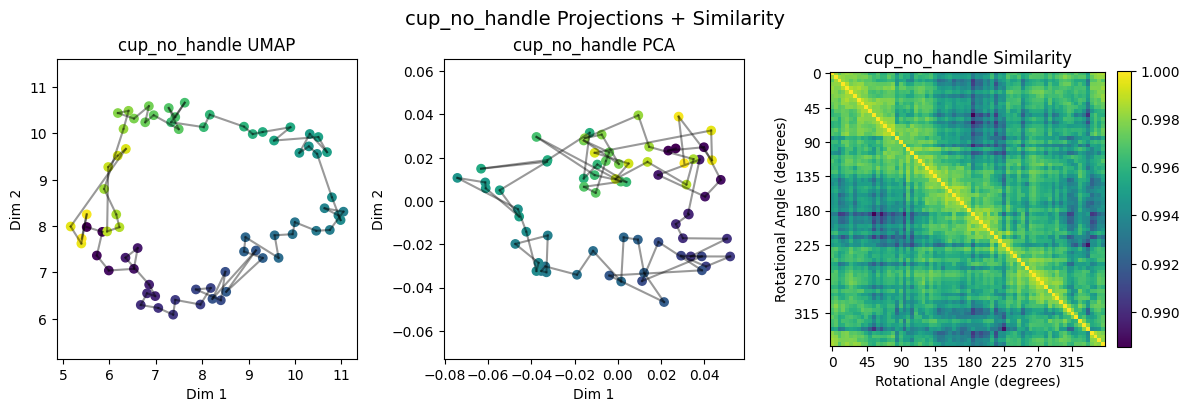

Analyzing 'charger'...


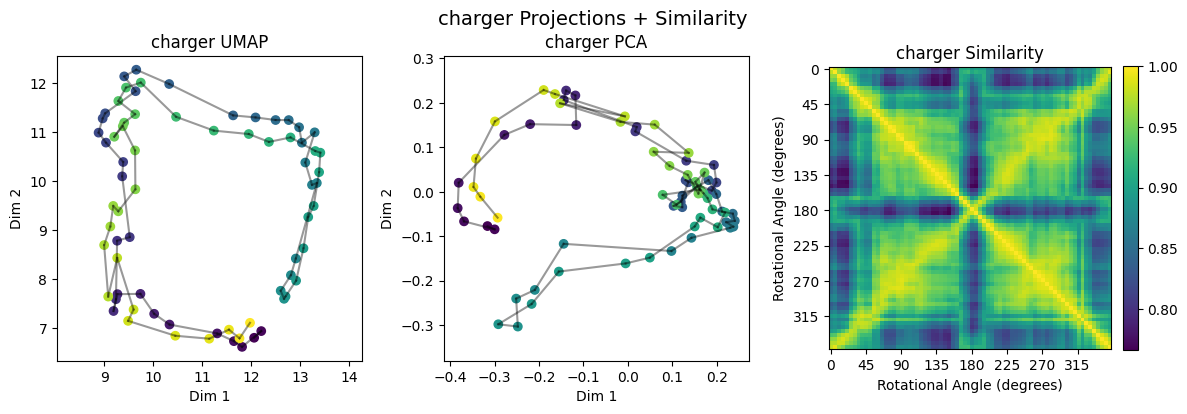

Analyzing 'rubiks_cube'...


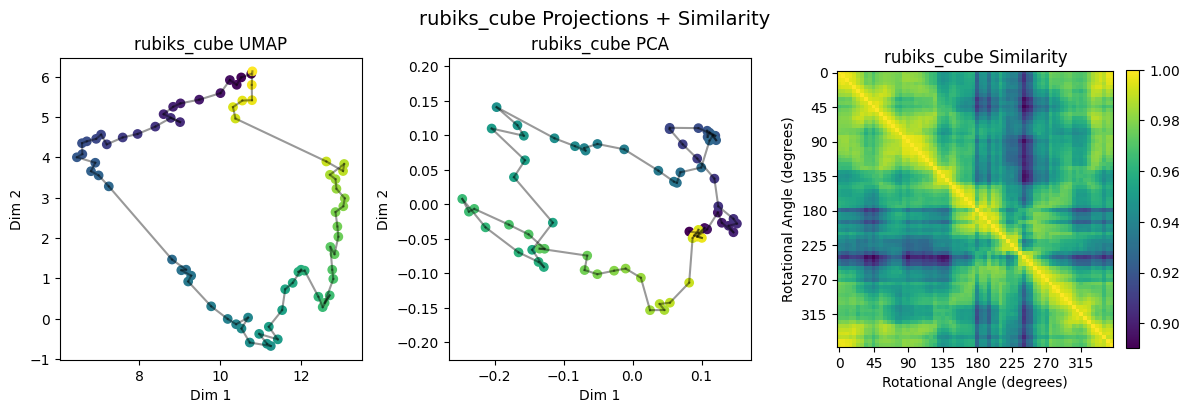

Analyzing 'rubber_duck'...


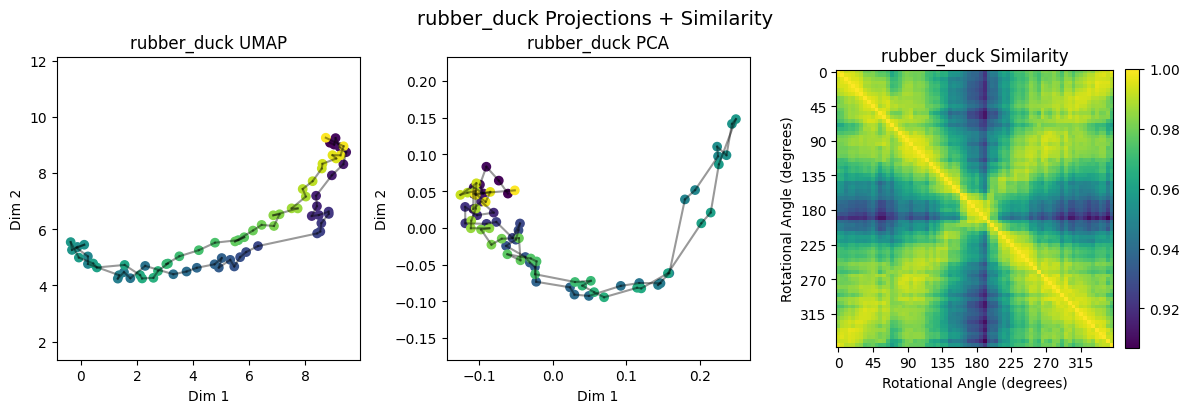

Analyzing 'battery'...


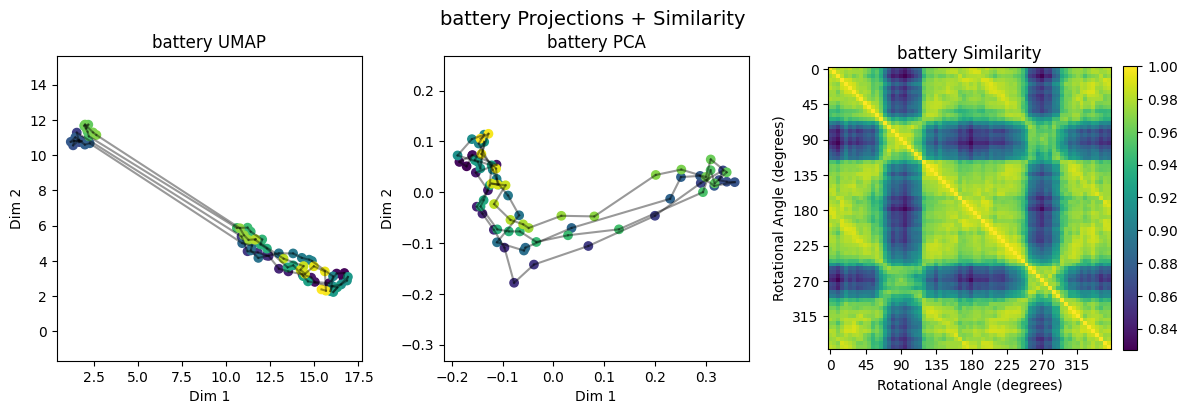

Analyzing 'thermo_cup'...


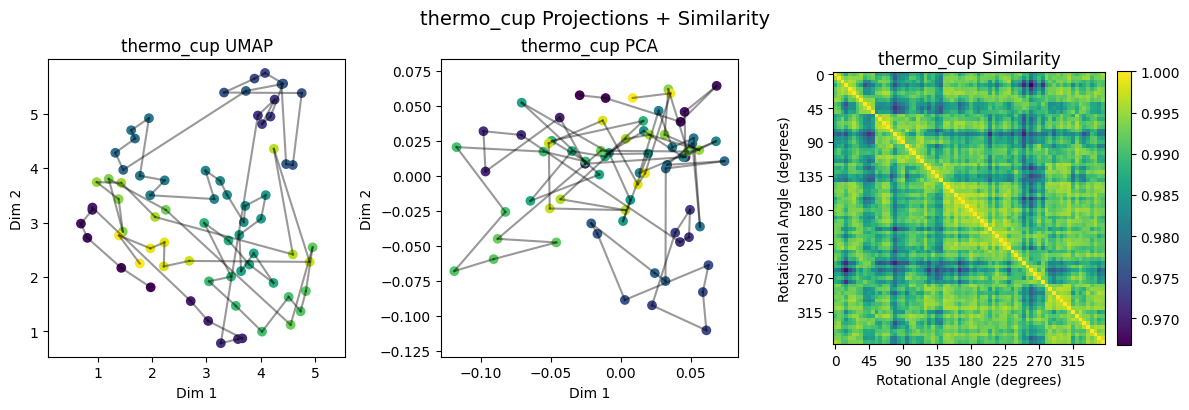

Analyzing 'light_bulb'...


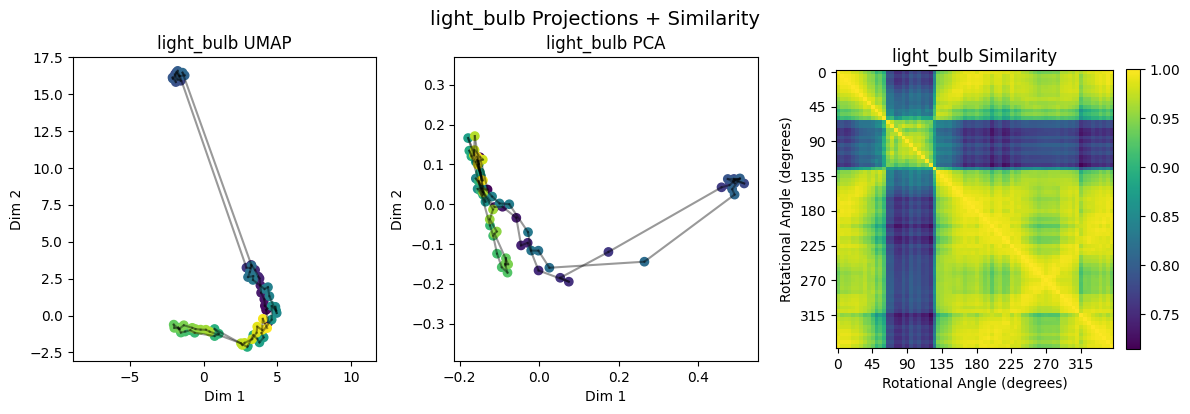

Analyzing 'cup_with_handle'...


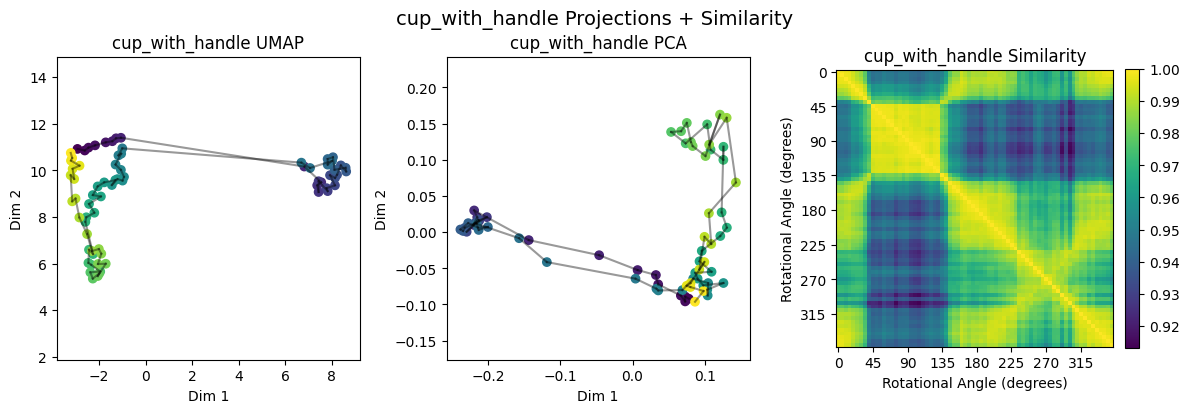

Analyzing 'combination_lock'...


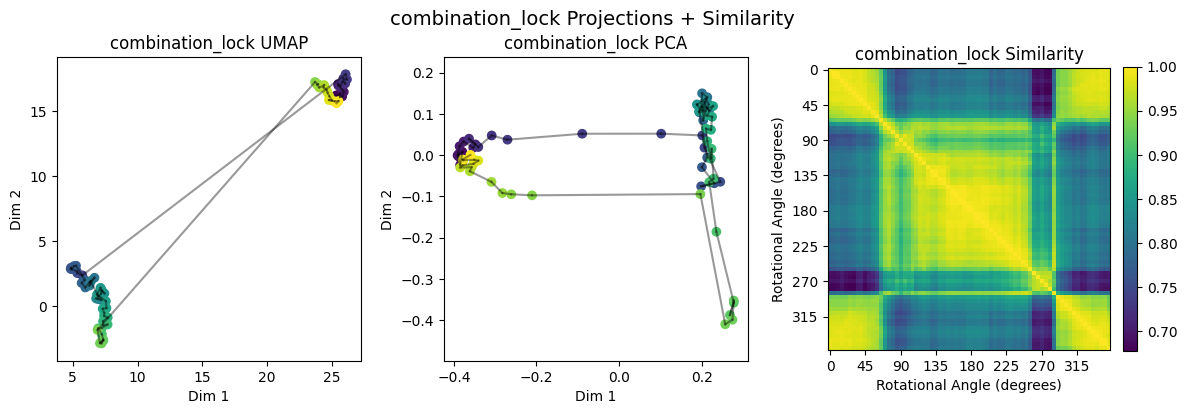

Analyzing 'wrist_watch'...


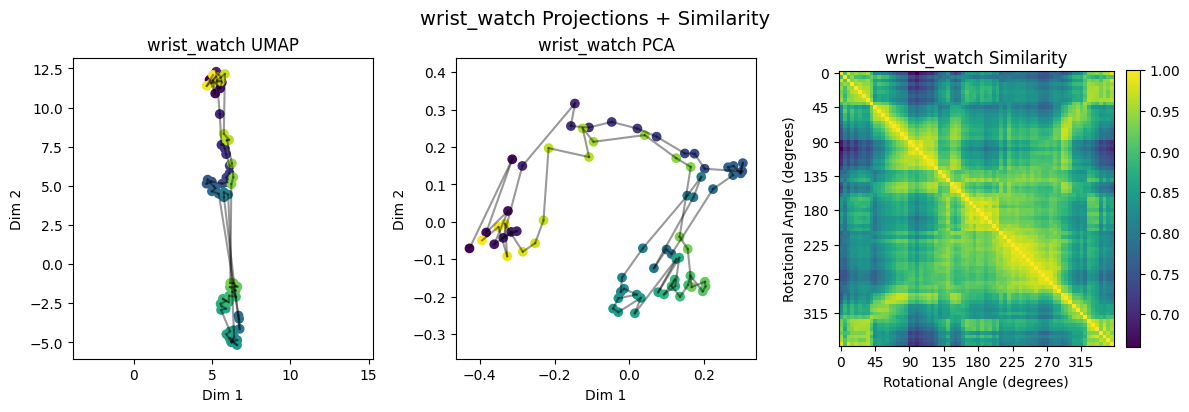

Analyzing 'toy_car'...


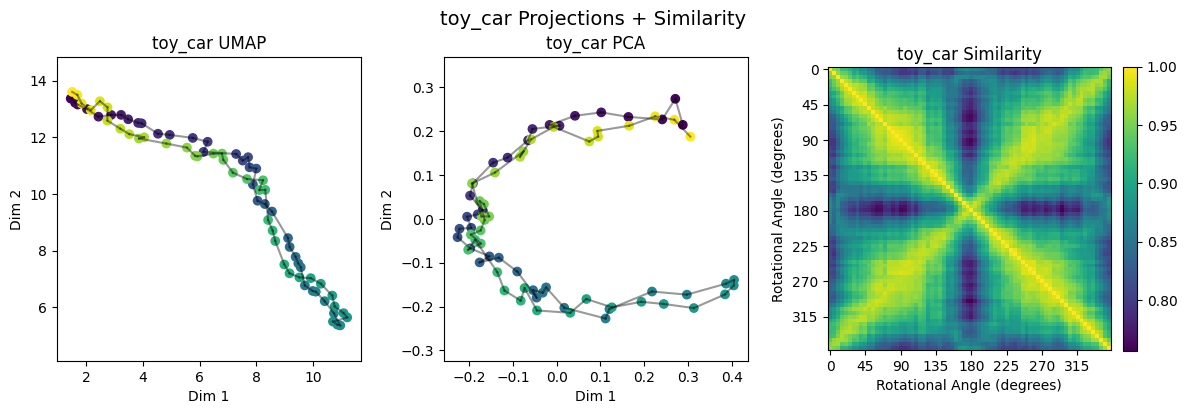

Analyzing 'lego_man'...


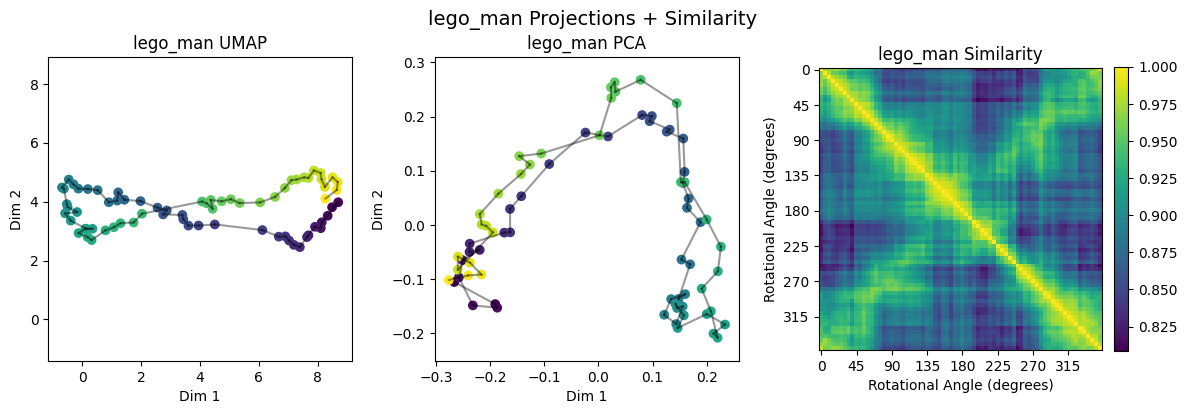

Analyzing 'sun_glasses'...


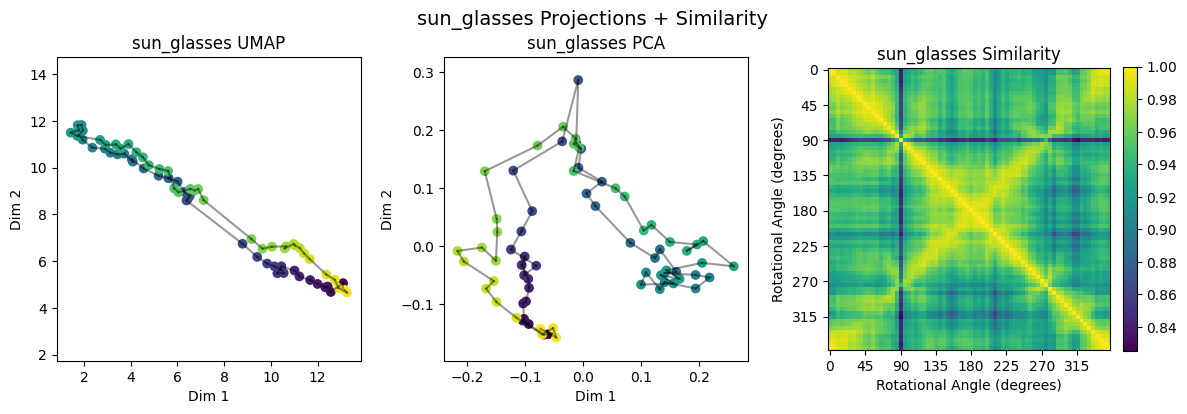

Analyzing 'faxe_kondi'...


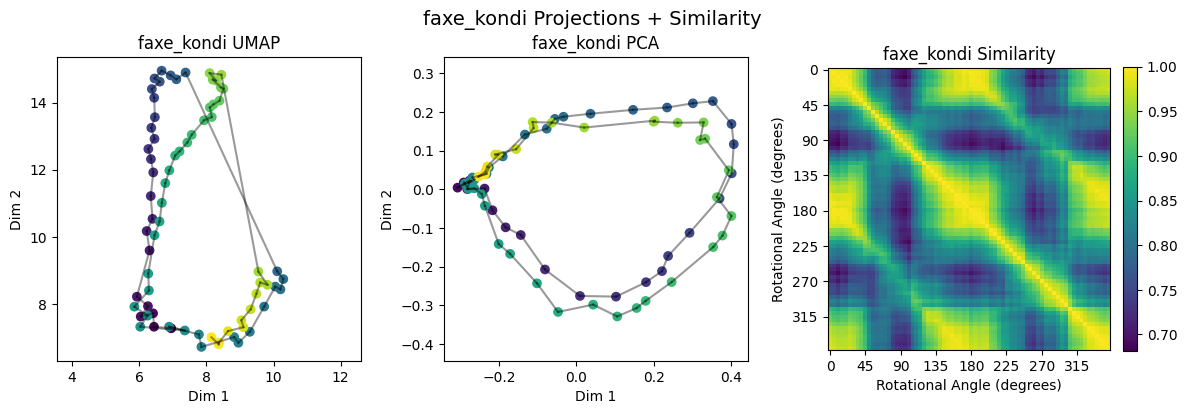

Analyzing 'lego_brick'...


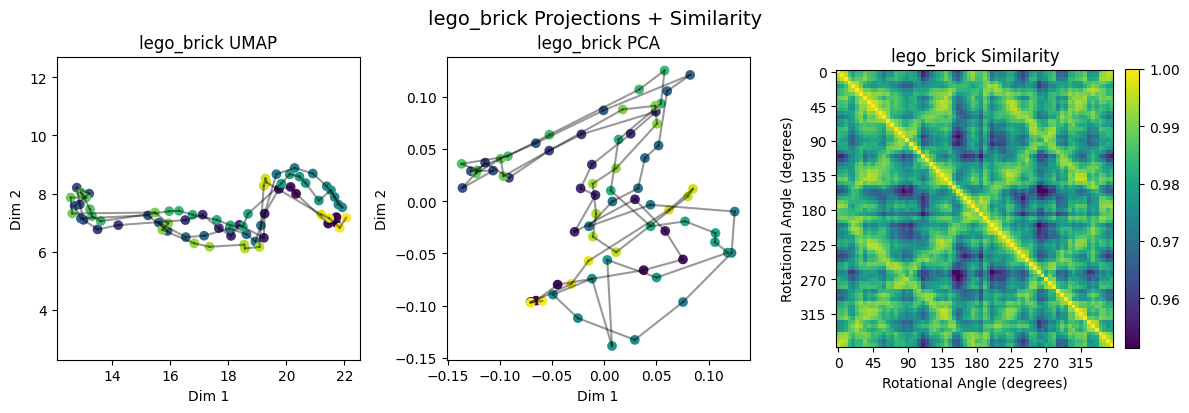

Analyzing 'controller'...


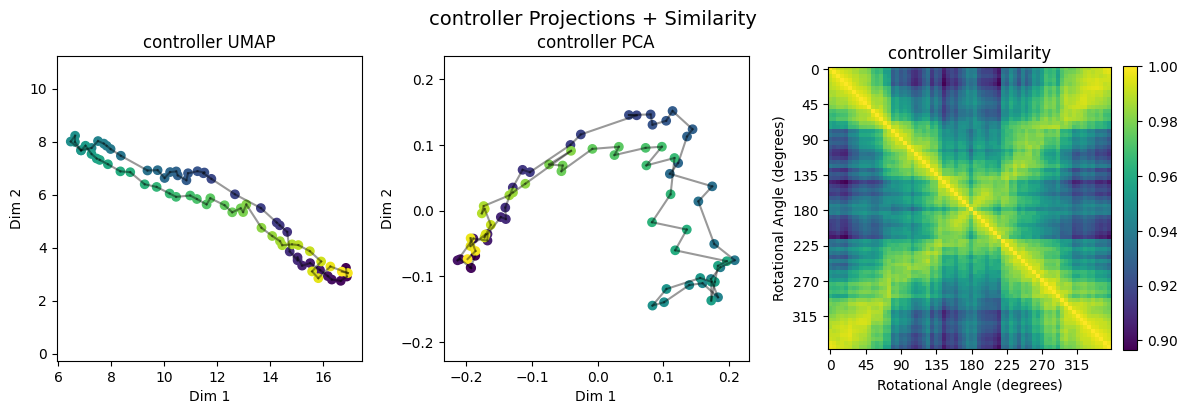

Analyzing 'duct_tape'...


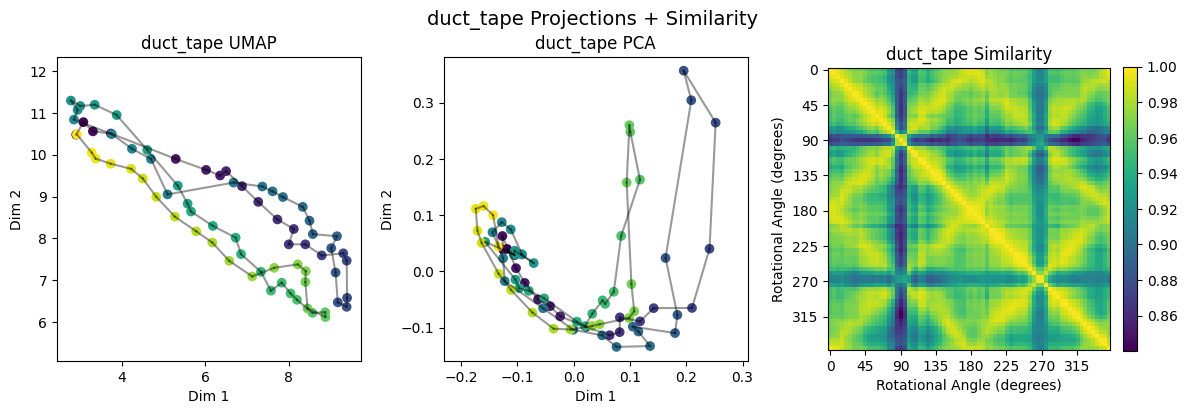


=== SUMMARY TABLE ===
Object       | Original | UMAP   | PCA    | Δ UMAP   | Δ PCA   
---------------------------------------------------------------
cup_no_handle | 5        | 0      | 2      | -5++++++ | -3++++++
charger      | 0        | 0      | 0      | 0+++++++ | 0+++++++
rubiks_cube  | 2        | 2      | 0      | 0+++++++ | -2++++++
rubber_duck  | 3        | 1      | 0      | -2++++++ | -3++++++
battery      | 2        | 0      | 0      | -2++++++ | -2++++++
thermo_cup   | 2        | 1      | 3      | -1++++++ | 1+++++++
light_bulb   | 3        | 0      | 1      | -3++++++ | -2++++++
cup_with_handle | 4        | 7      | 0      | 3+++++++ | -4++++++
combination_lock | 2        | 8      | 1      | 6+++++++ | -1++++++
wrist_watch  | 0        | 0      | 0      | 0+++++++ | 0+++++++
toy_car      | 1        | 0      | 0      | -1++++++ | -1++++++
lego_man     | 0        | 0      | 0      | 0+++++++ | 0+++++++
sun_glasses  | 2        | 1      | 0      | -1++++++ | -2++++++
faxe_kond

In [11]:


# ---------------- CONFIG ----------------
WINDOW_SIZE = 2
THRESHOLD_MODE = "std"   # options: "std", "percentile"
THRESHOLD_VALUE = 2      # percentile (e.g., 97) or std multiplier (e.g., 2.0)
RANDOM_SEED = 42
# ----------------------------------------

def project_embeddings(embeddings: np.ndarray, method: str = "umap") -> np.ndarray:
    if method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'umap' or 'pca'")
    return reducer.fit_transform(embeddings)

def detect_breakdowns(lengths: np.ndarray, mode: str, value: float) -> Tuple[np.ndarray, float]:
    if mode == "std":
        mean = np.mean(lengths)
        std = np.std(lengths)
        threshold = mean + value * std
    elif mode == "percentile":
        threshold = np.percentile(lengths, value)
    else:
        raise ValueError("Threshold mode must be 'std' or 'percentile'.")

    mask = lengths > threshold
    return mask, threshold


def get_breakdown_mask(emb, label = "none"): #label not really used anymore
    _, length_cvs = sliding_window(emb, window=WINDOW_SIZE)
    threshold = np.percentile(length_cvs, THRESHOLD_VALUE) if THRESHOLD_MODE == "percentile" else (
        np.mean(length_cvs) + THRESHOLD_VALUE * np.std(length_cvs)
    )
    mask = np.array(length_cvs) > threshold
    return mask, threshold, length_cvs


def analyze_embedding(name: str, embeddings: np.ndarray, show_plot: bool = False, fig=None, axes=None) -> Dict[str, int]:
    result = {}

    # --- RAW EMBEDDINGS ---
    raw_mask, raw_thresh, raw_cvs = get_breakdown_mask(embeddings, "RAW")
    result["original"] = int(np.sum(raw_mask))

    # --- UMAP ---
    emb_umap = project_embeddings(embeddings, "umap")
    umap_mask, umap_thresh, umap_cvs = get_breakdown_mask(emb_umap, "UMAP")
    result["umap"] = int(np.sum(umap_mask))

    # --- PCA ---
    emb_pca = project_embeddings(embeddings, "pca")
    pca_mask, pca_thresh, pca_cvs = get_breakdown_mask(emb_pca, "PCA")
    result["pca"] = int(np.sum(pca_mask))

    # --- PLOTTING ---
    if show_plot and fig is not None and axes is not None:
        def plot_trajectory(ax, data, title):
            min_vals = data.min(axis=0)
            max_vals = data.max(axis=0)
            center = (max_vals + min_vals) / 2
            rng = np.max(max_vals - min_vals)
            padding = rng * 0.05

            cmap = plt.get_cmap("viridis")
            norm = Normalize(vmin=0, vmax=len(data) - 1)

            for i in range(1, len(data)):
                ax.plot([data[i-1, 0], data[i, 0]],
                        [data[i-1, 1], data[i, 1]], 'k-', alpha=0.4)
            ax.scatter(data[:, 0], data[:, 1], c=np.arange(len(data)), cmap=cmap, norm=norm)
            ax.set_title(title)
            ax.set_xlabel("Dim 1")
            ax.set_ylabel("Dim 2")
            ax.set_xlim(center[0] - rng/2-padding, center[0] + rng/2+padding)
            ax.set_ylim(center[1] - rng/2-padding, center[1] + rng/2+padding)
            ax.set_aspect('equal', 'box')

        # UMAP plot
        plot_trajectory(axes[0], emb_umap, f"{name} UMAP")

        # PCA plot
        plot_trajectory(axes[1], emb_pca, f"{name} PCA")

        # Heatmap plot
        sim_matrix = cosine_similarity_matrix(embeddings)
        min_val = np.min(sim_matrix)
        max_val = np.max(sim_matrix)
        im = axes[2].imshow(sim_matrix, cmap="viridis", vmin=min_val, vmax=max_val)
        axes[2].set_title(f"{name} Similarity")
        axes[2].set_xlabel("Rotational Angle (degrees)")
        axes[2].set_ylabel("Rotational Angle (degrees)")
        num_ticks = sim_matrix.shape[0]
        tick_locs = np.arange(0, num_ticks, max(1, num_ticks // 8))
        tick_labels = [str(i * 5) for i in tick_locs]
        axes[2].set_xticks(tick_locs)
        axes[2].set_yticks(tick_locs)
        axes[2].set_xticklabels(tick_labels)
        axes[2].set_yticklabels(tick_labels)
        plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

        #Want to include cool circle plot here axes[3] = circular_CV(param,param):

    return result


def batch_analyze(embedding_dict: Dict[str, np.ndarray], show_plot: bool = False):
    all_results = {}

    for key in embedding_dict:
        emb = embedding_dict[key]
        print(f"Analyzing '{key}'...")
        if show_plot:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            results = analyze_embedding(key, emb, show_plot=True, fig=fig, axes=axes)
            plt.suptitle(f"{key} Projections + Similarity", fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            results = analyze_embedding(key, emb, show_plot=False)

        all_results[key] = results

    # Summary Table
    print("\n=== SUMMARY TABLE ===")
    header = f"{'Object':<12} | {'Original':<8} | {'UMAP':<6} | {'PCA':<6} | {'Δ UMAP':<8} | {'Δ PCA':<8}"
    print(header)
    print("-" * len(header))
    for key, res in all_results.items():
        o, u, p = res["original"], res["umap"], res["pca"]
        delta_u, delta_p = u - o, p - o
        print(f"{key:<12} | {o:<8} | {u:<6} | {p:<6} | {delta_u:+<8} | {delta_p:+<8}")

    return all_results

# Example usage
if __name__ == "__main__":

    batch_analyze(embedding_dict, show_plot=True)


In [12]:
from scipy.stats import ttest_rel
import numpy as np

# Small statistics test
umap_counts = np.array([
    3, 0, 0, 0, 0, 3, 8, 3, 6, 0, 0, 3, 0, 4, 0, 0, 0
])
pca_counts = np.array([
    2, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0
])

# Paired t-test
t_stat, p_value = ttest_rel(umap_counts, pca_counts)

print(f"Paired t-test: t = {t_stat:.3f}, p = {p_value:.4f}")


diffs = umap_counts - pca_counts
from scipy.stats import shapiro

stat, p_shapiro = shapiro(diffs)
print(f"Shapiro-Wilk test: W = {stat:.3f}, p = {p_shapiro:.4f}")

# We cant use this test, have to use ranked

Paired t-test: t = 2.364, p = 0.0311
Shapiro-Wilk test: W = 0.744, p = 0.0004


In [13]:
from scipy.stats import wilcoxon

stat, p_wilcoxon = wilcoxon(umap_counts, pca_counts)
print(f"Wilcoxon signed-rank test: W = {stat}, p = {p_wilcoxon:.4f}")

Wilcoxon signed-rank test: W = 1.5, p = 0.0340


Validating OpenClip's loss function:

In [14]:
import torch
import torch.nn.functional as F

# Step 1: Raw logits (unnormalized scores)
logits = torch.tensor([
    [2.0, 1.0, 0.1],   # image 0
    [0.5, 2.5, 0.3],   # image 1
    [0.3, 0.2, 3.0]    # image 2
], dtype=torch.float32)

# Step 2: Correct class indices (diagonal alignment)
labels = torch.tensor([0, 1, 2])  # each image matches same-index text

# Step 3: Built-in cross entropy
loss_builtin = F.cross_entropy(logits, labels)  # default: reduction='mean'
print("Built-in CE loss:", loss_builtin.item())

Built-in CE loss: 0.2525131404399872


In [15]:
# Step 4: Softmax over rows
probs = F.softmax(logits, dim=1)
print(probs)
# Step 5: Pick the probability of the correct class for each sample
row_indices = torch.arange(len(labels))
correct_probs = probs[row_indices, labels]  # [p_00, p_11, p_22]
print(correct_probs)
# Step 6: Take negative log, then mean
manual_loss = -torch.log(correct_probs).mean()
print("Manual CE loss:   ", manual_loss.item())


tensor([[0.6590, 0.2424, 0.0986],
        [0.1086, 0.8025, 0.0889],
        [0.0596, 0.0539, 0.8865]])
tensor([0.6590, 0.8025, 0.8865])
Manual CE loss:    0.2525131404399872


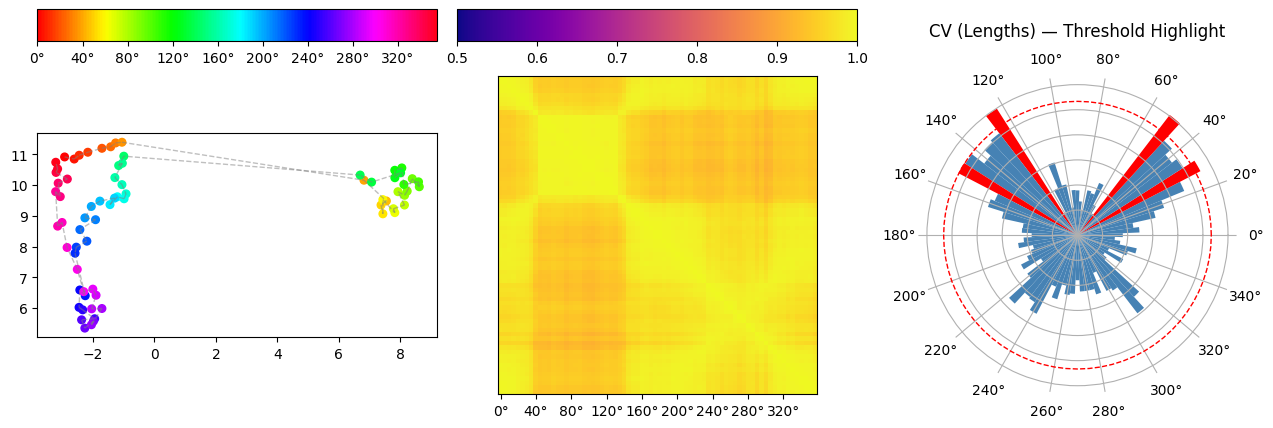

In [16]:
key = 'cup_with_handle'
embeddings = embedding_dict[key]
mask, threshold, length_cvs = get_breakdown_mask(embeddings)

##########
import matplotlib.gridspec as gridspec

# --- Data prep ---
angles = np.linspace(0, 2 * np.pi, len(length_cvs), endpoint=False)
bar_width = 2 * np.pi / len(length_cvs)
colors = ['red' if v > threshold else 'steelblue' for v in length_cvs]

# --- Degree ticks every 40°, including 360° ---
degrees = np.arange(0, 360, 40)  # 0° to 360°
tick_positions = degrees / 5     # convert degrees to frame indices

# --- Layout setup ---
fig = plt.figure(figsize=(16, 5), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, height_ratios=[0.1, 1], width_ratios=[1, 1, 1], hspace=0.2, wspace=0.05)

# Axes
ax_cb1 = fig.add_subplot(gs[0, 0])  # UMAP colorbar
ax_cb2 = fig.add_subplot(gs[0, 1])  # Heatmap colorbar
ax1    = fig.add_subplot(gs[1, 0])  # UMAP
ax2    = fig.add_subplot(gs[1, 1])  # Heatmap
ax3    = fig.add_subplot(gs[1, 2], projection='polar')  # Circular


ax1.set_aspect('equal', adjustable='box')  # force square shape for UMAP
ax2.set_aspect('equal')    
ax1.axis('on')  # cleaner look

# --- UMAP ---
def plot_trajectory(ax, data):
    cmap = plt.get_cmap("hsv")
    norm = Normalize(vmin=0, vmax=len(data) - 1)
    for i in range(1, len(data)):
        ax.plot([data[i-1, 0], data[i, 0]], [data[i-1, 1], data[i, 1]],
                linestyle='--', color='gray', alpha=0.5, linewidth=1)
    sc = ax.scatter(data[:, 0], data[:, 1], c=np.arange(len(data)), cmap=cmap, norm=norm, s=30)
    return sc

proj = project_embeddings(embeddings)
sc = plot_trajectory(ax1, proj)

# UMAP colorbar

cbar1 = fig.colorbar(sc, cax=ax_cb1, orientation='horizontal',fraction=0.046, pad=0.04)
cbar1.set_ticks(tick_positions)
cbar1.set_ticklabels([f"{int(d)}°" for d in degrees])

# --- Heatmap ---
sim_matrix = cosine_similarity_matrix(embeddings)
im = ax2.imshow(sim_matrix, cmap="plasma", vmin=0.5, vmax=1.0)

ax2.set_yticks([])  # remove y-axis
ax2.set_xticks(tick_positions)
ax2.set_xticklabels([f"{int(d)}°" for d in degrees])
ax2.tick_params(top=False, bottom=True, labelbottom=True)

ax2.set_title("")

# Heatmap colorbar
cbar2 = fig.colorbar(im, cax=ax_cb2, orientation='horizontal',fraction=0.046, pad=0.04)


# --- Circular Histogram ---
bars = ax3.bar(angles, length_cvs, width=bar_width, color=colors, edgecolor='none')
threshold_ring = np.full_like(angles, threshold)
ax3.plot(np.append(angles, angles[0]), np.append(threshold_ring, threshold), '--', color='red', linewidth=1)

# Circular ticks every 20°
ax3.set_xticks(np.deg2rad(np.arange(0, 360, 20)))
ax3.set_xticklabels([f"{i}°" for i in range(0, 360, 20)])
ax3.set_yticklabels([])
ax3.grid(True)
ax3.spines['polar'].set_visible(False)
ax3.set_title("CV (Lengths) — Threshold Highlight", y=1.1)

plt.show()


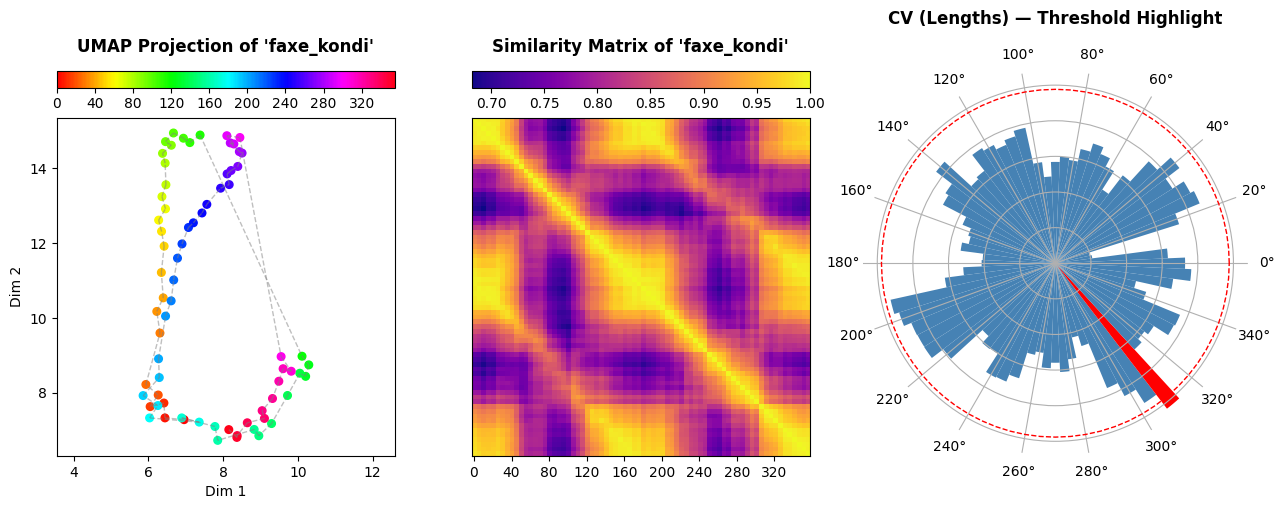

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

key = 'faxe_kondi'
embeddings = embedding_dict[key]
mask, threshold, length_cvs = get_breakdown_mask(embeddings)

# --- Data prep ---
angles = np.linspace(0, 2 * np.pi, len(length_cvs), endpoint=False)
bar_width = 2 * np.pi / len(length_cvs)
colors = ['red' if v > threshold else 'steelblue' for v in length_cvs]
degrees = np.arange(0, 360, 40)
tick_positions = degrees / 5

# --- Layout setup ---
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.01)

# Create axes - now with constrained layout for better spacing
ax1 = fig.add_subplot(gs[0])  # UMAP
ax2 = fig.add_subplot(gs[1])  # Heatmap
ax3 = fig.add_subplot(gs[2], projection='polar')  # Circular

# Make UMAP and Heatmap square
ax1.set_aspect('auto')  # This allows different scaling but will make plot area square
ax2.set_aspect('equal')  # Heatmap should be square

# --- UMAP ---
def plot_trajectory(ax, data, title):
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    center = (max_vals + min_vals) / 2
    rng = np.max(max_vals - min_vals)
    padding = rng * 0.05

    cmap = plt.get_cmap("hsv")
    norm = Normalize(vmin=0, vmax=len(data) - 1)

    for i in range(1, len(data)):
        ax.plot([data[i-1, 0], data[i, 0]], [data[i-1, 1], data[i, 1]],
                linestyle='--', color='gray', alpha=0.5, linewidth=1)
    sc = ax.scatter(data[:, 0], data[:, 1], c=np.arange(len(data)), cmap=cmap, norm=norm, s=30)
    ax.set_title(title, y=1.17, fontweight='bold')
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_xlim(center[0] - rng/2-padding, center[0] + rng/2+padding)
    ax.set_ylim(center[1] - rng/2-padding, center[1] + rng/2+padding)
    ax.set_aspect('equal', 'box')

    return ax, sc


proj = project_embeddings(embeddings)
ax1, sc = plot_trajectory(ax1, proj, f"UMAP Projection of '{key}'")

# UMAP colorbar (horizontal on top)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("top", size="5%", pad=0.3)
cbar1 = fig.colorbar(sc, cax=cax1, orientation='horizontal')
cbar1.set_ticks(tick_positions)
cbar1.set_ticklabels([f"{int(d)}" for d in degrees])

# --- Heatmap ---
sim_matrix = cosine_similarity_matrix(embeddings)
min_val = np.min(sim_matrix)
max_val = np.max(sim_matrix)
im = ax2.imshow(sim_matrix, cmap="plasma", vmin=min_val, vmax=max_val)
ax2.set_title(f"Similarity Matrix of '{key}'", y=1.17, fontweight='bold')
ax2.set_yticks([])
ax2.set_xticks(tick_positions)
ax2.set_xticklabels([f"{int(d)}" for d in degrees])

# Heatmap colorbar (horizontal on top)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("top", size="5%", pad=0.3)
fig.colorbar(im, cax=cax2, orientation='horizontal')

# --- Circular Histogram ---
bars = ax3.bar(angles, length_cvs, width=bar_width, color=colors, edgecolor='none')
threshold_ring = np.full_like(angles, threshold)
ax3.plot(np.append(angles, angles[0]), np.append(threshold_ring, threshold), 
        '--', color='red', linewidth=1)
ax3.set_xticks(np.deg2rad(np.arange(0, 360, 20)))
ax3.set_xticklabels([f"{i}°" for i in range(0, 360, 20)])
ax3.set_yticklabels([])
ax3.grid(True)
ax3.spines['polar'].set_visible(False)
ax3.set_title("CV (Lengths) — Threshold Highlight", y=1.1, fontweight='bold')


plt.tight_layout()
plt.show()